#  PREDICTING STOCK PRICE WITH LSTM NEURAL NETWORKS. By Augustine Ojo

## Importing Depepndencies and Libraries

In [3]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split  ## 80/20% Split for Train test
from sklearn.metrics import r2_score
from tensorflow import keras

In [4]:
stocks_df = pd.read_csv('/content/stcks_df.csv')#, parse_dates=['Date'], index_col='Date')
stocks_df.head(3)

,Date,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,GOOGL,GS,...,IBM,INTC,JNJ,KO,META,MSFT,NVDA,QQQ,SPY,XOM
0,2012-05-18 00:00:00+00:00,15.996172,10.6925,46.533325,57.249630,63.887566,11.279345,59.677826,14.987913,75.709747,...,116.428940,18.292822,44.516636,25.100883,38.115242,23.443844,0.276979,54.290005,103.318832,49.654617
1,2012-05-21 00:00:00+00:00,16.928110,10.9055,47.314480,59.427006,66.264969,11.416314,60.423359,15.330158,76.518456,...,117.546387,18.348953,44.600960,25.256802,33.927845,23.828302,0.281794,55.807716,105.094696,50.002022
2,2012-05-22 00:00:00+00:00,16.798122,10.7665,47.331264,59.178638,65.911972,11.457406,60.199085,14.997898,77.327133,...,116.987648,18.264761,44.636089,25.148336,30.906942,23.836313,0.278355,55.745228,105.277847,49.947166


In [5]:
# # Check the columns
# print(stocks_df.columns)

In [6]:
volume_df = pd.read_csv('/content/new_volume.csv').dropna() ##, parse_dates=['Date'], index_col='Date')
volume_df.head(3)

,Date,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,GOOGL,GS,...,IBM,INTC,JNJ,KO,META,MSFT,NVDA,QQQ,SPY,XOM
12683,2012-05-18 00:00:00+00:00,732292400.0,104634000.0,8783700.0,5597400,8655900,57520600.0,11137700,238701060.0,7184700.0,...,6001007,43444900.0,13781300,31913000,573576400.0,56205300.0,567288000.0,79496500.0,319615900.0,21747200
12684,2012-05-21 00:00:00+00:00,631106000.0,71596000.0,4568600.0,4709700,6811300,37628500.0,6169400,122892984.0,5314700.0,...,4007958,41389400.0,8784900,13488800,168192700.0,38787900.0,416260000.0,61473000.0,177861100.0,13730400
12685,2012-05-22 00:00:00+00:00,694870400.0,74662000.0,5858600.0,4269400,7210500,42979200.0,6089700,121953924.0,5839700.0,...,3731187,46037700.0,8409300,15260600,101786600.0,39504900.0,410140000.0,62954800.0,197531200.0,13790000


In [7]:
# Check the columns
print(volume_df.columns)

Index(['Date', 'AAPL', 'AMZN', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'GOOGL',
       'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'KO', 'META', 'MSFT', 'NVDA', 'QQQ',
       'SPY', 'XOM'],
      dtype='object')


In [8]:
stocks_df = stocks_df.sort_values(by = ['Date'])

In [9]:
volume_df = volume_df.sort_values(by = ['Date'])

In [10]:
volume_df.shape

(3112, 21)

# **DATA PREPARATION FOR AI AND MACHINE LEARNING**

In [11]:
# Function to return the input/output (target) data for AI/ML Model
# Note that the goal is to predict the future stock price
# Target stock price today will be tomorrow's price
def trading_window(data, col):

  n = 1   # 1 day window

  # Create a column containing the prices for the next 1 days
  data['Target'] = data[[col]].shift(-n)

  # return the new dataset
  return data

In [12]:
# where Target Column is the Next Day Value of Google

display(trading_window(stocks_df, "GOOGL").head(3))
display(trading_window(stocks_df, "GOOGL").tail(3))
## The last rading on the target stock has a NaN due to -1 shift

,Date,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,GOOGL,GS,...,INTC,JNJ,KO,META,MSFT,NVDA,QQQ,SPY,XOM,Target
0,2012-05-18 00:00:00+00:00,15.996172,10.6925,46.533325,57.249630,63.887566,11.279345,59.677826,14.987913,75.709747,...,18.292822,44.516636,25.100883,38.115242,23.443844,0.276979,54.290005,103.318832,49.654617,15.330158
1,2012-05-21 00:00:00+00:00,16.928110,10.9055,47.314480,59.427006,66.264969,11.416314,60.423359,15.330158,76.518456,...,18.348953,44.600960,25.256802,33.927845,23.828302,0.281794,55.807716,105.094696,50.002022,14.997898
2,2012-05-22 00:00:00+00:00,16.798122,10.7665,47.331264,59.178638,65.911972,11.457406,60.199085,14.997898,77.327133,...,18.264761,44.636089,25.148336,30.906942,23.836313,0.278355,55.745228,105.277847,49.947166,15.214080


,Date,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,GOOGL,GS,...,INTC,JNJ,KO,META,MSFT,NVDA,QQQ,SPY,XOM,Target
3109,2024-09-27 00:00:00+00:00,227.789993,187.970001,271.059998,156.320007,391.079987,53.020000,145.490005,163.949997,498.510010,...,23.910000,161.399994,71.790001,567.359985,428.019989,121.400002,486.750000,571.469971,115.820000,165.850006
3110,2024-09-30 00:00:00+00:00,233.000000,186.330002,271.200012,152.039993,391.119995,53.220001,147.270004,165.850006,495.109985,...,23.459999,162.059998,71.860001,572.440002,430.299988,121.440002,488.070007,573.760010,117.220001,166.304993
3111,2024-10-01 00:00:00+00:00,225.570007,185.059998,269.714996,155.039993,392.730011,52.764999,149.910004,166.304993,491.730011,...,22.635000,162.190002,71.964996,575.250000,421.839996,117.790100,480.910004,569.090027,119.629997,NaN


In [13]:
def individual_stock(price_df, vol_df, name):
    """
    Isolate and Concatenates the date, stock price, and volume in one dataframe.

    Args:
        price_df (pd.DataFrame): DataFrame containing stock prices.
        vol_df (pd.DataFrame): DataFrame containing stock volumes.
        name (str): Name of the stock.

    Returns:
        pd.DataFrame: DataFrame containing the date, stock price, and volume.
    """
    # Access the index which is 'Date' instead of a column
    return pd.DataFrame({'Date': price_df['Date'].values, 'Close': price_df[name].values, 'Volume': vol_df[name].values}) #'Date': price_df.index,

In [14]:
# Let's test the functions and get individual stock prices and volumes for GOOGLE
price_volume_df = individual_stock(stocks_df, volume_df, 'GOOGL')
display(price_volume_df.head(3))
display(price_volume_df.tail(3))

,Date,Close,Volume
0,2012-05-18 00:00:00+00:00,14.987913,238701060.0
1,2012-05-21 00:00:00+00:00,15.330158,122892984.0
2,2012-05-22 00:00:00+00:00,14.997898,121953924.0


,Date,Close,Volume
3109,2024-09-27 00:00:00+00:00,163.949997,21101300.0
3110,2024-09-30 00:00:00+00:00,165.850006,20413900.0
3111,2024-10-01 00:00:00+00:00,166.304993,13763445.0


In [15]:
# Checking the shape of the Dataset
price_volume_df.shape

(3112, 3)

In [16]:
# Isolating the columns required for Analysis
price_volume_tgt_df = trading_window(price_volume_df, col='Close')
display(price_volume_tgt_df.head(3))
display(price_volume_tgt_df.tail(3))

,Date,Close,Volume,Target
0,2012-05-18 00:00:00+00:00,14.987913,238701060.0,15.330158
1,2012-05-21 00:00:00+00:00,15.330158,122892984.0,14.997898
2,2012-05-22 00:00:00+00:00,14.997898,121953924.0,15.214080


,Date,Close,Volume,Target
3109,2024-09-27 00:00:00+00:00,163.949997,21101300.0,165.850006
3110,2024-09-30 00:00:00+00:00,165.850006,20413900.0,166.304993
3111,2024-10-01 00:00:00+00:00,166.304993,13763445.0,NaN


In [17]:
# Removing NaN values from Dataset
price_volume_tgt_df = price_volume_tgt_df[:-1]
display(price_volume_tgt_df.head(3))
display(price_volume_tgt_df.tail(3))

,Date,Close,Volume,Target
0,2012-05-18 00:00:00+00:00,14.987913,238701060.0,15.330158
1,2012-05-21 00:00:00+00:00,15.330158,122892984.0,14.997898
2,2012-05-22 00:00:00+00:00,14.997898,121953924.0,15.214080


,Date,Close,Volume,Target
3108,2024-09-26 00:00:00+00:00,162.729996,20319300.0,163.949997
3109,2024-09-27 00:00:00+00:00,163.949997,21101300.0,165.850006
3110,2024-09-30 00:00:00+00:00,165.850006,20413900.0,166.304993


In [18]:
# # Scaling the data with MinMaxScaler and to Keep the scaled values between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
price_volume_tgt_scaled_df = sc.fit_transform(price_volume_tgt_df.drop(columns = ['Date']))

In [19]:
# Displaying the Arrays of the dataset
price_volume_tgt_scaled_df

array([[0.00583276, 0.47016909, 0.00776667],
       [0.00776667, 0.23280216, 0.00588918],
       [0.00588918, 0.23087741, 0.00711075],
       ...,
       [0.8406708 , 0.0225612 , 0.84756459],
       [0.84756459, 0.02416403, 0.85830087],
       [0.85830087, 0.0227551 , 0.86087184]])

In [20]:
# checking the data shape
price_volume_tgt_scaled_df.shape

(3111, 3)

In [21]:
###  [:, :2]:  selecting  ALL Rows and 1st 2 columns of the Array
X = price_volume_tgt_scaled_df[:, :2]
y = price_volume_tgt_scaled_df[:, 2:]

In [22]:
# Converting dataframe to arrays
# X = np.asarray(X)
# y = np.asarray(y)
X.shape, y.shape

((3111, 2), (3111, 1))

In [23]:
# Dsiplaying X Values
X

array([[0.00583276, 0.47016909],
       [0.00776667, 0.23280216],
       [0.00588918, 0.23087741],
       ...,
       [0.8406708 , 0.0225612 ],
       [0.84756459, 0.02416403],
       [0.85830087, 0.0227551 ]])

In [24]:
# Dsiplaying Y Values
y

array([[0.00776667],
       [0.00588918],
       [0.00711075],
       ...,
       [0.84756459],
       [0.85830087],
       [0.86087184]])

In [25]:
# Splitting the dataset into X and y values
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [26]:
# Checking Dataset after splitting
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2488, 2), (623, 2), (2488, 1), (623, 1))

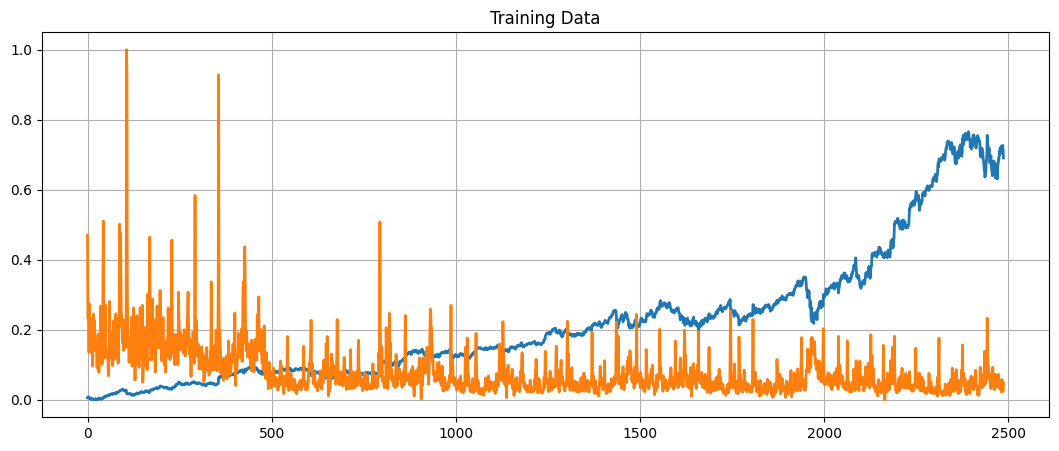

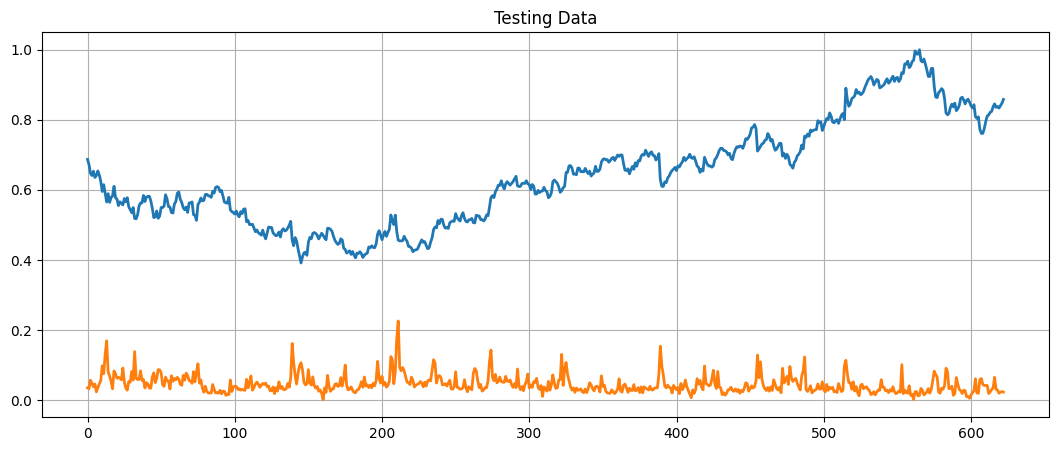

In [27]:
# Defining a data plotting function
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 2)
  plt.title(title)
  #plt.xlabel('Date')  # Label for the X-axis
  plt.grid()

show_plot(X_train, 'Training Data')
show_plot(X_test, 'Testing Data')

### **X_train X_test Plot:** The chart visualizes the Training (80% of the data) and Testing data which is 20% of the dataset and their respective volumes.

## APPLYING NEURAL NETWORK (LSTM) TO DATASET

In [28]:
price_volume_df = individual_stock(stocks_df, volume_df, 'NVDA')
display(price_volume_df.head(3))
display(price_volume_df.tail(3))

,Date,Close,Volume
0,2012-05-18 00:00:00+00:00,0.276979,567288000.0
1,2012-05-21 00:00:00+00:00,0.281794,416260000.0
2,2012-05-22 00:00:00+00:00,0.278355,410140000.0


,Date,Close,Volume
3109,2024-09-27 00:00:00+00:00,121.400002,271009200.0
3110,2024-09-30 00:00:00+00:00,121.440002,226553700.0
3111,2024-10-01 00:00:00+00:00,117.790100,147240209.0


In [29]:
## Selecting ALL Rows and Columns values at index at 1 to 3 excluding 3
training_data = price_volume_df.iloc[:, 1:3].values
training_data

array([[2.76978791e-01, 5.67288000e+08],
       [2.81793863e-01, 4.16260000e+08],
       [2.78354555e-01, 4.10140000e+08],
       ...,
       [1.21400002e+02, 2.71009200e+08],
       [1.21440002e+02, 2.26553700e+08],
       [1.17790100e+02, 1.47240209e+08]])

In [30]:
#Checking fot the shape of the dataset
training_data.shape

(3112, 2)

In [31]:
# Normalize the data to between 0 and 1 with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)

In [32]:
# Create the training and testing data, training data contains present day and previous day values
X = []
y = []
for i in range(1, len(price_volume_df)):
    X.append(training_set_scaled [i-1:i, 0])
    y.append(training_set_scaled [i, 0])

In [33]:
X

[array([0.00011862]),
 array([0.00015421]),
 array([0.00012879]),
 array([0.00017962]),
 array([0.0001237]),
 array([0.00017284]),
 array([0.00022707]),
 array([0.00020165]),
 array([0.00017793]),
 array([0.00010167]),
 array([5.9309732e-05]),
 array([0.00011692]),
 array([0.00017115]),
 array([8.64221797e-05]),
 array([0.0001254]),
 array([0.00014912]),
 array([0.00019149]),
 array([0.00013556]),
 array([0.00011015]),
 array([0.00015421]),
 array([0.00017284]),
 array([0.00031519]),
 array([0.00035077]),
 array([0.00024741]),
 array([0.00027452]),
 array([0.00020504]),
 array([0.00022877]),
 array([0.00029824]),
 array([0.00031519]),
 array([0.00041347]),
 array([0.00035077]),
 array([0.00041008]),
 array([0.00038636]),
 array([0.0003423]),
 array([0.0003118]),
 array([0.00024402]),
 array([0.00020843]),
 array([0.00017284]),
 array([0.00019996]),
 array([0.00020674]),
 array([0.00016776]),
 array([0.00028469]),
 array([0.00030672]),
 array([0.00024232]),
 array([0.00027113]),
 array(

In [34]:
# Convert the data into array format
X = np.asarray(X)
y = np.asarray(y)

In [35]:
# Split the data
split = int(0.70 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [36]:
# Reshaping the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((2177, 1, 1), (934, 1, 1))

In [37]:
# Create the model, using linear activiation to prevent saturation from sigmoid activiation

inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))  # Two input Columns
x = keras.layers.LSTM(150, return_sequences= True)(inputs) ## adding the layers
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.2)(x)
# x = keras.layers.LSTM(150, return_sequences=True)(x)
# x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(150)(x)

# Dense layer for Outputting the results
outputs = keras.layers.Dense(1, activation='linear')(x)  ## Linear Activation prevents saturation

# Building and Compiling the Model
model = keras.Model(inputs=inputs, outputs=outputs)
compile_model = model.compile(optimizer='adam', loss='mse', metrics=['mae'])  ## minimisng the mean square error (MSE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 150)              │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 150)              │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.6034e-04 - mae: 0.0132 - val_loss: 0.0024 - val_mae: 0.0412
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2853e-04 - mae: 0.0132 - val_loss: 0.0025 - val_mae: 0.0429
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0570e-04 - mae: 0.0124 - val_loss: 9.3464e-04 - val_mae: 0.0265
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4523e-05 - mae: 0.0043 - val_loss: 1.0151e-05 - val_mae: 0.0025
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4888e-06 - mae: 0.0015 - val_loss: 3.9899e-06 - val_mae: 0.0014
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7937e-06 - mae: 0.0012 - val_loss: 3.8726e-06 - val_mae: 0.0014
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3647e-06 - mae: 0.0014 - val_loss: 3.6681e-06 - val_mae: 0.0013
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.2662e-06 - mae: 0.0011 - val_loss: 4.5627e-06 - val_mae: 0.0015
Epoch 9/

In [39]:
# Make prediction
predicted = model.predict(X)

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [40]:
summary = pd.DataFrame(history.history)
summary

,loss,mae,val_loss,val_mae
0,0.000245,0.013261,0.002374,0.041158
1,0.000234,0.013171,0.002491,0.042924
2,0.000187,0.011557,0.000935,0.026488
3,0.000017,0.002888,0.000010,0.002506
4,0.000003,0.001441,0.000004,0.001383
5,0.000003,0.001233,0.000004,0.001375
6,0.000003,0.001260,0.000004,0.001298
7,0.000002,0.001069,0.000005,0.001539
8,0.000003,0.001225,0.000005,0.001704
9,0.000002,0.001139,0.000004,0.001295


In [41]:
# Append the predicted values to the list
test_predicted = []

for i in predicted:
  test_predicted.append(i[0])

In [42]:
test_predicted

[-0.0002740689,
 -0.00023832056,
 -0.0002638551,
 -0.00021278742,
 -0.000268962,
 -0.00021959678,
 -0.00016512396,
 -0.00019065826,
 -0.00021448964,
 -0.00029109186,
 -0.0003336477,
 -0.00027577183,
 -0.00022129831,
 -0.0003064121,
 -0.00026726048,
 -0.00024342746,
 -0.00020087184,
 -0.00025704596,
 -0.0002825805,
 -0.00023832056,
 -0.00021959678,
 -7.660594e-05,
 -4.085852e-05,
 -0.00014469889,
 -0.00011746073,
 -0.00018725335,
 -0.00016342243,
 -9.362912e-05,
 -7.660594e-05,
 2.2125198e-05,
 -4.0858286e-05,
 1.8720282e-05,
 -5.1110983e-06,
 -4.9370807e-05,
 -8.001248e-05,
 -0.00014810218,
 -0.00018384866,
 -0.00021959678,
 -0.00019236095,
 -0.00018555112,
 -0.00022470322,
 -0.00010724785,
 -8.5118925e-05,
 -0.0001498051,
 -0.00012086518,
 -0.00014469889,
 -0.000102140475,
 -9.192759e-05,
 -3.5751145e-05,
 -6.128661e-05,
 -2.553803e-05,
 -5.1072333e-05,
 -4.2560278e-05,
 5.1022507e-06,
 5.4467004e-05,
 7.8299316e-05,
 9.191758e-05,
 0.00017362693,
 0.00015830575,
 0.00019064941,
 0.00

In [43]:
# Nomalizing the close values
close = []
for i in training_set_scaled:
    close.append(i[0])

In [44]:
close

[0.00011861924372216651,
 0.0001542053912745047,
 0.00012878693470769285,
 0.0001796238478413161,
 0.00012370319934307305,
 0.000172844799834199,
 0.00022707189774024208,
 0.0002016532209171435,
 0.00017792897571139357,
 0.0001016733857546713,
 5.930973198922662e-05,
 0.00011692437159224354,
 0.00017115080872942556,
 8.642217966081276e-05,
 0.00012539719044784734,
 0.0001491216559098849,
 0.00019148597044419107,
 0.00013556488143337455,
 0.00011014598435398794,
 0.0001542053912745047,
 0.000172844799834199,
 0.00031518939004355215,
 0.00035077487682702883,
 0.00024740529740471156,
 0.00027451972738288134,
 0.0002050423044081275,
 0.00022876544833244205,
 0.0002982426510509083,
 0.00031518939004355215,
 0.0004134734720509527,
 0.00035077487682702883,
 0.0004100846088162559,
 0.0003863603636105055,
 0.0003423013972025635,
 0.0003117992052711323,
 0.00024401753545145012,
 0.00020843138789911194,
 0.000172844799834199,
 0.00019995812853093337,
 0.0002067365157691894,
 0.0001677619454947287

#### Isolating Requisite Column Values

In [45]:
df_predicted = price_volume_df[1:][['Date']]
df_predicted.head(5)

,Date
1,2012-05-21 00:00:00+00:00
2,2012-05-22 00:00:00+00:00
3,2012-05-23 00:00:00+00:00
4,2012-05-24 00:00:00+00:00
5,2012-05-25 00:00:00+00:00


In [46]:
df_predicted['Predictions'] = test_predicted

In [47]:
df_predicted

,Date,Predictions
1,2012-05-21 00:00:00+00:00,-0.000274
2,2012-05-22 00:00:00+00:00,-0.000238
3,2012-05-23 00:00:00+00:00,-0.000264
4,2012-05-24 00:00:00+00:00,-0.000213
5,2012-05-25 00:00:00+00:00,-0.000269
...,...,...
3107,2024-09-25 00:00:00+00:00,0.832187
3108,2024-09-26 00:00:00+00:00,0.847692
3109,2024-09-27 00:00:00+00:00,0.850786
3110,2024-09-30 00:00:00+00:00,0.835311


In [48]:
df_predicted['Close'] = close[1:]

In [49]:
df_predicted

,Date,Predictions,Close
1,2012-05-21 00:00:00+00:00,-0.000274,0.000154
2,2012-05-22 00:00:00+00:00,-0.000238,0.000129
3,2012-05-23 00:00:00+00:00,-0.000264,0.000180
4,2012-05-24 00:00:00+00:00,-0.000213,0.000124
5,2012-05-25 00:00:00+00:00,-0.000269,0.000173
...,...,...,...
3107,2024-09-25 00:00:00+00:00,0.832187,0.910881
3108,2024-09-26 00:00:00+00:00,0.847692,0.914798
3109,2024-09-27 00:00:00+00:00,0.850786,0.895287
3110,2024-09-30 00:00:00+00:00,0.835311,0.895583


In [50]:
# Defining the Function to make INTERACTIVE plots using "Plotly Express"
def interactive_plot(df_predicted, title):
  fig = px.line(title = title)
  for i in df_predicted.columns[1:]:
    fig.add_scatter( x=df_predicted['Date'], y = df_predicted[i], name = 'NVDA') ## Defining the Function to make interactive plots using Plotly Express

  fig.show()

### An Interactive Plot of Original Stock Prices vs LSTM Neural Network  Predicted Prices

In [51]:
interactive_plot(df_predicted, "Original Stock Prices vs LSTM Predicted Prices")

#### An interactive plot of the last 300 periods

In [52]:
interactive_plot(df_predicted[-300:], "Original NVDA Stock Prices vs LSTM Predicted Prices")

### Observation and Inferences:
 * The predcited values from the model are very tightly corrlated with the actual values.
 *

In [53]:
diff_df = ((df_predicted['Close'] - df_predicted['Predictions'])/df_predicted['Close'])*100
# Add diff_df as a new column to df_predicted
df_predicted['Pred Diff %'] = diff_df
df_predicted

,Date,Predictions,Close,Pred Diff %
1,2012-05-21 00:00:00+00:00,-0.000274,0.000154,277.729784
2,2012-05-22 00:00:00+00:00,-0.000238,0.000129,285.050260
3,2012-05-23 00:00:00+00:00,-0.000264,0.000180,246.893131
4,2012-05-24 00:00:00+00:00,-0.000213,0.000124,272.014482
5,2012-05-25 00:00:00+00:00,-0.000269,0.000173,255.608963
...,...,...,...,...
3107,2024-09-25 00:00:00+00:00,0.832187,0.910881,8.639415
3108,2024-09-26 00:00:00+00:00,0.847692,0.914798,7.335694
3109,2024-09-27 00:00:00+00:00,0.850786,0.895287,4.970613
3110,2024-09-30 00:00:00+00:00,0.835311,0.895583,6.729864


## **Observation and Inferences With LSTM Neural Network Model :**
* LSTM is one of the best models for times series predictions among other
* Long Short Term Memory Networks Model (LSTM) demostrated a continously improving prediction with time.
* It requires a lot of data to reach a stable and very tight prediction with the dataset.
* This model will requires more work, probably some parametal tuning to further improve performance.

